In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)
# from xgboost import XGBRegressor
from catboost import CatBoostRegressor
# from lightgbm import LGBMRegressor
from scipy.fftpack import fft
from sklearn.preprocessing import PowerTransformer, TargetEncoder
from sklearn.decomposition import PCA
from statsmodels.tsa.seasonal import STL
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import copy
from pytorch_forecasting import TimeSeriesDataSet
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from torchmetrics import MeanSquaredError
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer

In [ ]:
RANDOM_STATE = 23
N_TRIALS = 25
FILE_PATH = 'currency_raw.parquet'
FILE_TYPE = 'currency'
TICKER = 'USDRUB'
TICKER_TYPE = 'Open'
WINDOW_SIZE = 10

In [ ]:

def preprocess_time_series(
    df: pd.DataFrame,
    target: str,
    transformers: dict = None,
    do_scale: bool = True,
    do_diff: bool = True,
    do_yeo_johnson: bool = True,
    do_window_normalizing: bool = True,
    window_size: int = 10,
    do_encode: bool = True,
    is_train: bool = False
):
    """
    Предобрабатывает временной ряд для столбца 'target' в DataFrame, изменяя только этот столбец,
    с возможностью восстановления исходных значений. Учитывает data leakage.

    Параметры:
    ----------
    df : pd.DataFrame
        Исходный DataFrame.
    target : str
        Название столбца, для которого выполняются преобразования.
    transformers : dict, optional
        Словарь с объектами трансформеров (используется при is_train=False).
    do_scale : bool, по умолчанию True
        Выполнять ли масштабирование.
    do_diff : bool, по умолчанию True
        Выполнять ли дифференцирование.
    do_yeo_johnson : bool, по умолчанию True
        Выполнять ли преобразование Yeo-Johnson.
    do_window_normalizing : bool, по умолчанию True
        Выполнять ли оконную нормализацию.
    window_size : int, по умолчанию 10
        Размер окна для оконной нормализации.
    do_encode : bool
        Выполнять ли кодировку категориальных признаков.
    is_train : bool, по умолчанию True
        Флаг, указывающий, являются ли данные тренировочными.

    Возвращает:
    -----------
    df_transformed : pd.DataFrame
        Преобразованный DataFrame с только изменённым столбцом 'target'.
    transformers : dict
        Словарь с объектами трансформеров для восстановления значений.
    """
    df_transformed = df.copy()
    ts = df_transformed[target].copy()

    if is_train:
        transformers = {}
    elif transformers is None:
        raise ValueError('Для тестовых данных необходимо передать transformers.')

    # Масштабирование.
    if do_scale:
        values = ts.values.reshape(-1, 1)

        if is_train:
            scaler = StandardScaler()
            scaled_values = scaler.fit_transform(values)
            transformers['scaler'] = scaler
        else:
            scaler = transformers['scaler']
            scaled_values = scaler.transform(values)

        ts = pd.Series(
            data=scaled_values.flatten(),
            index=ts.index,
            name=ts.name
        )

    # Дифференцирование.
    if do_diff:
        transformers['last_value'] = ts.iloc[0]
        ts = ts.diff()
        ts.dropna(inplace=True)

    # Преобразование Yeo-Johnson.
    if do_yeo_johnson:
        if is_train:
            pt = PowerTransformer(method='yeo-johnson', standardize=False)
            non_nan_values = ts.values[~np.isnan(ts.values)].reshape(-1, 1)
            if len(non_nan_values) > 0:
                pt.fit(non_nan_values)
            transformers['yeo_johnson'] = pt

        pt = transformers['yeo_johnson']
        transformed_values = np.full_like(ts.values, np.nan, dtype=float)
        non_nan_mask = ~np.isnan(ts.values)
        non_nan_values = ts.values[non_nan_mask].reshape(-1, 1)

        if len(non_nan_values) > 0:
            transformed_values[non_nan_mask] = pt.transform(non_nan_values).flatten()

        ts = pd.Series(transformed_values, index=ts.index, name=ts.name)

    # Оконная нормализация.
    if do_window_normalizing:
        ts_rolled = ts.rolling(window=window_size)
        rolled_mean = ts_rolled.mean()
        rolled_std = ts_rolled.std()
        transformers['rolled_mean'] = rolled_mean
        transformers['rolled_std'] = rolled_std
        transformers['window_init_values'] = ts.iloc[:window_size - 1].values.copy()

        eps = 1e-9
        ts = (ts - rolled_mean) / (rolled_std + eps)
        ts = ts[window_size - 1:]


    df_transformed[target] = ts
    df_transformed.dropna(inplace=True)

    if do_encode:
        if is_train:
            encoder = TargetEncoder(cv=3, random_state=RANDOM_STATE)
            df_transformed['ticker'] = encoder.fit_transform(X=df_transformed[['ticker']], y=ts)

            transformers['encoder'] = encoder
        else:
            encoder = transformers['encoder']
            df_transformed['ticker'] = encoder.transform(X=df_transformed[['ticker']])

    return df_transformed.set_index('Date'), transformers


def inverse_preprocess_time_series(
    ts_transformed: np.array,
    transformers: dict,
    do_scale: bool = True,
    do_diff: bool = True,
    do_yeo_johnson: bool = True,
    do_window_normalizing: bool = True,
    window_size: int = 10
) -> np.array:
    """
    Восстанавливает исходный временной ряд из преобразованного np.array,
    используя сохранённые параметры трансформаций, выполненных в функции preprocess_time_series.

    Параметры:
    -----------
    ts_transformed : np.array
        Преобразованный временной ряд.
    transformers : dict
        Словарь с сохранёнными объектами и параметрами трансформаций.
    do_scale : bool, по умолчанию True
        Выполнять ли масштабирование.
    do_diff : bool, по умолчанию True
        Выполнять ли дифференцирование.
    do_yeo_johnson : bool, по умолчанию True
        Выполнять ли преобразование Yeo-Johnson.
    do_window_normalizing : bool, по умолчанию True
        Выполнять ли оконную нормализацию.
    window_size : int, по умолчанию 10
        Размер окна для оконной нормализации.

    Возвращает:
    -----------
    np.array
        Восстановленный временной ряд в исходных единицах измерения.
    """
    ts = ts_transformed.copy()

    # 1. Обратная оконная нормализация
    if do_window_normalizing:
        eps = 1e-9
        rolled_mean = transformers.get('rolled_mean')
        rolled_std = transformers.get('rolled_std')
        init_values = transformers.get('window_init_values', np.array([]))
        window = transformers.get('window')

        if rolled_mean is None or rolled_std is None:
            raise ValueError("Нет данных для обратной оконной нормализации.")

        ts = ts * (rolled_std.values[window_size - 1:window_size - 1 + len(ts)] + eps) + rolled_mean.values[window_size - 1:window_size - 1 + len(ts)]
        ts = np.concatenate([init_values, ts])

    # 2. Обратное Yeo-Johnson
    if do_yeo_johnson and 'yeo_johnson' in transformers:
        pt = transformers['yeo_johnson']
        ts = pt.inverse_transform(ts.reshape(-1, 1)).flatten()

    # 3. Обратное дифференцирование
    if do_diff and 'last_value' in transformers:
        ts = np.cumsum(ts, dtype=np.float64) + transformers['last_value']

    # 4. Обратное масштабирование
    if do_scale and 'scaler' in transformers:
        scaler = transformers['scaler']
        ts = scaler.inverse_transform(ts.reshape(-1, 1)).flatten()

    return ts[window_size - 1:]


def inverse_preprocess_time_series(
    ts_transformed: np.array,
    transformers: dict,
    do_scale: bool = True,
    do_diff: bool = True,
    do_yeo_johnson: bool = True,
    do_window_normalizing: bool = True,
    window_size: int = 10
) -> np.array:
    """
    Восстанавливает исходный временной ряд из преобразованного np.array,
    используя сохранённые параметры трансформаций, выполненных в функции preprocess_time_series.

    Параметры:
    -----------
    ts_transformed : np.array
        Преобразованный временной ряд.
    transformers : dict
        Словарь с сохранёнными объектами и параметрами трансформаций.
    do_scale : bool, по умолчанию True
        Выполнять ли масштабирование.
    do_diff : bool, по умолчанию True
        Выполнять ли дифференцирование.
    do_yeo_johnson : bool, по умолчанию True
        Выполнять ли преобразование Yeo-Johnson.
    do_window_normalizing : bool, по умолчанию True
        Выполнять ли оконную нормализацию.
    window_size : int, по умолчанию 10
        Размер окна для оконной нормализации.

    Возвращает:
    -----------
    np.array
        Восстановленный временной ряд в исходных единицах измерения.
    """
    ts = ts_transformed.copy()

    # 1. Обратная оконная нормализация
    if do_window_normalizing:
        eps = 1e-9
        rolled_mean = transformers.get('rolled_mean')
        rolled_std = transformers.get('rolled_std')
        init_values = transformers.get('window_init_values', np.array([]))
        window = transformers.get('window')

        if rolled_mean is None or rolled_std is None:
            raise ValueError("Нет данных для обратной оконной нормализации.")

        ts = ts * (rolled_std.values[window_size - 1:window_size - 1 + len(ts)] + eps) + rolled_mean.values[window_size - 1:window_size - 1 + len(ts)]
        ts = np.concatenate([init_values, ts])

    # 2. Обратное Yeo-Johnson
    if do_yeo_johnson and 'yeo_johnson' in transformers:
        pt = transformers['yeo_johnson']
        ts = pt.inverse_transform(ts.reshape(-1, 1)).flatten()

    # 3. Обратное дифференцирование
    if do_diff and 'last_value' in transformers:
        ts = np.cumsum(ts, dtype=np.float64) + transformers['last_value']

    # 4. Обратное масштабирование
    if do_scale and 'scaler' in transformers:
        scaler = transformers['scaler']
        ts = scaler.inverse_transform(ts.reshape(-1, 1)).flatten()

    return ts[window_size - 1:]


def extract_time_series_features(
    df: pd.Series,
    lags=[1, 2, 3, 4, 5],
    rolling_windows=[7, 30],
    fourier_periods=[7, 30]
):
    """
    Функция для автоматического извлечения признаков из временного ряда.

    Аргументы:
      df : pandas.Series или pandas.DataFrame
          Временной ряд с индексом типа datetime.
      lags : list, по умолчанию [1, 2, 3, 4, 5]
          Лаговые признаки.
      rolling_windows : list, по умолчанию [3, 5, 7, 9]
          Скользящие статистики.
      fourier_periods : list, по умолчанию [7, 30]
          Периоды для Фурье-признаков.

    Возвращает:
      DataFrame с извлеченными признаками.
    """
    if isinstance(df, pd.Series):
        df = df.to_frame(name='value')
    else:
        df = df.copy()

        if 'value' not in df.columns:
            df = df.iloc[:, [0]]
            df.columns = ['value']

    df = df.sort_index()

    # Календарные признаки.
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Лаговые признаки.
    for lag in lags:
        df[f'lag_{lag}'] = df['value'].shift(lag)

    # Разностные признаки.
    for lag in lags:
        df[f'diff_{lag}'] = df['value'] - df['value'].shift(lag)

    # Скользящие статистики.
    for window in rolling_windows:
        df[f'rolling_mean_{window}'] = df['value'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['value'].rolling(window=window).std()
        df[f'rolling_min_{window}'] = df['value'].rolling(window=window).min()
        df[f'rolling_max_{window}'] = df['value'].rolling(window=window).max()

    # Признаки Фурье.
    t = np.arange(len(df))

    for period in fourier_periods:
        df[f'sin_{period}'] = np.sin(2 * np.pi * t / period)
        df[f'cos_{period}'] = np.cos(2 * np.pi * t / period)

    # Анализ Фурье.
    ts_filled = df['value'].ffill().values
    fft_values = fft(ts_filled)
    fft_power = np.abs(fft_values)**2
    dominant_idx = np.argmax(fft_power[1:]) + 1
    dominant_frequency = dominant_idx / len(df)
    df['dominant_frequency'] = dominant_frequency

    # Групповые статистики.
    df['weekday_mean'] = df.groupby(df['Date'].dt.dayofweek)['value'].transform('mean')
    df['weekday_std'] = df.groupby(df['Date'].dt.dayofweek)['value'].transform('std')
    df['weekday_min'] = df.groupby(df['Date'].dt.dayofweek)['value'].transform('min')
    df['weekday_max'] = df.groupby(df['Date'].dt.dayofweek)['value'].transform('max')

    for window in rolling_windows:
        df[f'rolling_median_{window}'] = df['value'].rolling(window=window).median()
        df[f'rolling_q25_{window}'] = df['value'].rolling(window=window).quantile(0.25)
        df[f'rolling_q75_{window}'] = df['value'].rolling(window=window).quantile(0.75)

    # Признаки на основе статистических моделей.
    stl = STL(df['value'].ffill(), period=12, seasonal=7)
    res = stl.fit()

    df['stl_trend'] = res.trend
    df['stl_seasonal'] = res.seasonal
    df['stl_residual'] = res.resid

    # Целевая переменная.
    df['target'] = df['value']
    df.drop(columns=['value'], inplace=True)
    df.dropna(inplace=True)

    return df


def split_time_series(
        df: pd.DataFrame,
        ticker: str,
        train_size=0.7,
        val_size=0.2,
        test_size=0.1
):
    """
    Разбивает отсортированный временной ряд на обучающую, валидационную и тестовую выборки.

    Parameters:
      df : pd.DataFrame
        Временной ряд.
      ticker : str
        Тикер для фильтрации тестовых данных.
      train_size : float
        Пропорция обучающей выборки.
      val_size : float
        Пропорция валидационной выборки.
      test_size : float
        Пропорция тестовой выборки.

    Returns:
      df_train, df_val, df_test : pd.DataFrame
        Разделённые данные.
    """
    df_train_list, df_val_list, df_test_list = [], [], []

    for ticker, group in df.groupby('ticker'):
        group = group.sort_values(by='Date')

        n = len(group)
        train_end = int(n * train_size)
        val_end = train_end + int(n * val_size)

        df_train_list.append(group.iloc[:train_end])
        df_val_list.append(group.iloc[train_end:val_end])
        df_test_list.append(group.iloc[val_end:])

    df_train = pd.concat(df_train_list).reset_index(drop=True)
    df_val = pd.concat(df_val_list).reset_index(drop=True)
    df_test = pd.concat(df_test_list).reset_index(drop=True)

    df_test = df_test[df_test['ticker'] == 'USDRUB']

    return df_train, df_val, df_test


def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
    }

    model = XGBRegressor(
        **params,
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        verbosity=0
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_cb(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0)
    }

    model = CatBoostRegressor(
        **params,
        random_state=RANDOM_STATE,
        thread_count=-1,
        verbose=0
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 31, 255),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
    }

    model = LGBMRegressor(
        **params,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    model = RandomForestRegressor(
        **params,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_ab(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3)
    }

    model = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=3),
        **params,
        random_state=RANDOM_STATE
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def objective_dt(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    model = DecisionTreeRegressor(
        **params,
        random_state=RANDOM_STATE
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    return mean_squared_error(y_val, preds)


def read_data(
        file_path: str,
        file_type: str,
        ticker_type: str
) -> pd.DataFrame:
    """
    Чтение и преобразование данных.

    Parameters
    ----------
    file_path : str
        Путь до файла.
    file_type : str
        Тип файла (currency, stock).
    ticker_type : str
        Название типа тикера для считывания.

    Returns
    -------
    df : pd.DataFrame
        Кадр данных.
    """
    df = pd\
        .read_parquet(file_path)\
        .reset_index()\
        .ffill()

    df = pd.melt(frame=df, id_vars='Date', var_name='series_id', value_name='value')

    if file_type == 'currency':
        df['ticker'] = df.apply(
            func=lambda row: row['series_id'].split('=X_')[0],
            axis=1
        )
        df['ticker_type'] = df.apply(
            func=lambda row: row['series_id'].split('=X_')[1],
            axis=1
        )

        df = df[df['ticker_type'] == ticker_type]
        df.drop(columns=['series_id', 'ticker_type'], inplace=True)

    elif file_type == 'stock':
        df['ticker'] = df['series_id']
        df.drop(columns=['series_id'], inplace=True)

    return df


# Загрузка данных

In [ ]:
df = read_data(
    file_path=FILE_PATH,
    file_type=FILE_TYPE,
    ticker_type=TICKER_TYPE
)

# Выделение выборок

In [ ]:
df_train, df_val, df_test = split_time_series(df=df, ticker=TICKER)

In [ ]:
df_train

,Date,value,ticker
0,2023-01-02 00:00:00+00:00,3.672060,USDAED
1,2023-01-03 00:00:00+00:00,3.671700,USDAED
2,2023-01-04 00:00:00+00:00,3.672000,USDAED
3,2023-01-05 00:00:00+00:00,3.672000,USDAED
4,2023-01-06 00:00:00+00:00,3.672000,USDAED
...,...,...,...
61375,2024-04-06 00:00:00+01:00,24.720978,USDZMW
61376,2024-04-07 00:00:00+01:00,24.720978,USDZMW
61377,2024-04-08 00:00:00+01:00,24.596031,USDZMW
61378,2024-04-09 00:00:00+01:00,24.519283,USDZMW


# Предобработка и конструирование признаков

In [ ]:
df_train = extract_time_series_features(df=df_train)
df_val = extract_time_series_features(df=df_val)
df_test = extract_time_series_features(df=df_test)

In [ ]:
df_train, transformers_train = preprocess_time_series(df=df_train, target='target', is_train=True)
df_val, transformers_val = preprocess_time_series(df=df_val, target='target', transformers=transformers_train)
df_test, transformers_test = preprocess_time_series(df=df_test, target='target', transformers=transformers_train)

In [ ]:
X_train = df_train.drop(columns=['target'])
y_train = df_train['target']

X_val = df_val.drop(columns=['target'])
y_val = df_val['target']

X_test = df_test.drop(columns=['target'])
y_test = df_test['target']

# Моделирование

## Подбор гиперпараметров

In [ ]:
# study_xgb = optuna.create_study(direction='minimize')
# study_xgb.optimize(objective_xgb, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

study_cb = optuna.create_study(direction='minimize')
study_cb.optimize(objective_cb, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

# study_lgbm = optuna.create_study(direction='minimize')
# study_lgbm.optimize(objective_lgbm, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

study_ab = optuna.create_study(direction='minimize')
study_ab.optimize(objective_ab, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

study_dt = optuna.create_study(direction='minimize')
study_dt.optimize(objective_dt, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=-1)

## Обучение моделей

In [ ]:
X_train = pd.concat(objs=[X_train, X_val])
y_train = pd.concat(objs=[y_train, y_val])

In [ ]:
xgb = XGBRegressor(
    **study_xgb.best_params,
    objective='reg:squarederror',
    random_state=RANDOM_STATE,
    verbosity=0
)
xgb.fit(X=X_train, y=y_train)
y_pred_xgb = xgb.predict(X=X_test)

mse_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred_xgb)
mae_xgb = mean_absolute_error(y_true=y_test, y_pred=y_pred_xgb)
mape_xgb = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_xgb)

In [ ]:
cb = CatBoostRegressor(
    **study_cb.best_params,
    random_state=RANDOM_STATE,
    thread_count=-1
)
cb.fit(X=X_train, y=y_train)
y_pred_cb = cb.predict(X_test)

mse_cb = mean_squared_error(y_true=y_test, y_pred=y_pred_cb)
mae_cb = mean_absolute_error(y_true=y_test, y_pred=y_pred_cb)
mape_cb = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_cb)

In [ ]:
lgbm = LGBMRegressor(
    **study_lgbm.best_params,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
lgbm.fit(X=X_train, y=y_train)
y_pred_lgbm = lgbm.predict(X=X_test)

mse_lgbm = mean_squared_error(y_true=y_test, y_pred=y_pred_lgbm)
mae_lgbm = mean_absolute_error(y_true=y_test, y_pred=y_pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_lgbm)

In [ ]:
rf = RandomForestRegressor(
    **study_rf.best_params,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X=X_train, y=y_train)
y_pred_rf = rf.predict(X=X_test)

mse_rf = mean_squared_error(y_true=y_test, y_pred=y_pred_rf)
mae_rf = mean_absolute_error(y_true=y_test, y_pred=y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_rf)

In [ ]:
ab = AdaBoostRegressor(
    **study_ab.best_params,
    random_state=RANDOM_STATE,
)
ab.fit(X=X_train, y=y_train)
y_pred_ab = ab.predict(X=X_test)

mse_ab = mean_squared_error(y_true=y_test, y_pred=y_pred_ab)
mae_ab = mean_absolute_error(y_true=y_test, y_pred=y_pred_ab)
mape_ab = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_ab)

In [ ]:
dt = DecisionTreeRegressor(
    **study_dt.best_params,
    random_state=RANDOM_STATE,
)
dt.fit(X=X_train, y=y_train)
y_pred_dt = dt.predict(X=X_test)

mse_dt = mean_squared_error(y_true=y_test, y_pred=y_pred_dt)
mae_dt = mean_absolute_error(y_true=y_test, y_pred=y_pred_dt)
mape_dt = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred_dt)

# Оценка моделей

In [ ]:
df_models = pd.DataFrame(
    data=None,
    columns=['Model', 'MSE', 'MAE', 'MAPE'],
    index=None
)

# df_models.loc[0] = ['XGBRegressor', mse_xgb, mae_xgb, mape_xgb]
df_models.loc[1] = ['CatBoostRegressor', mse_cb, mae_cb, mape_cb]
# df_models.loc[2] = ['LGBMRegressor', mse_lgbm, mae_lgbm, mape_lgbm]
df_models.loc[3] = ['RandomForestRegressor', mse_rf, mae_rf, mape_rf]
df_models.loc[4] = ['AdaBoostRegressor', mse_ab, mae_ab, mape_ab]
df_models.loc[5] = ['DecisionTreeRegressor', mse_dt, mae_dt, mape_dt]

df_models.sort_values(by=['MSE', 'MAE', 'MAPE'], ascending=True)

,Model,MSE,MAE,MAPE
1,CatBoostRegressor,0.061866,0.175632,0.834109
5,DecisionTreeRegressor,0.151019,0.264720,1.009315
3,RandomForestRegressor,0.177725,0.315689,1.404392
4,AdaBoostRegressor,0.481565,0.532578,2.747508


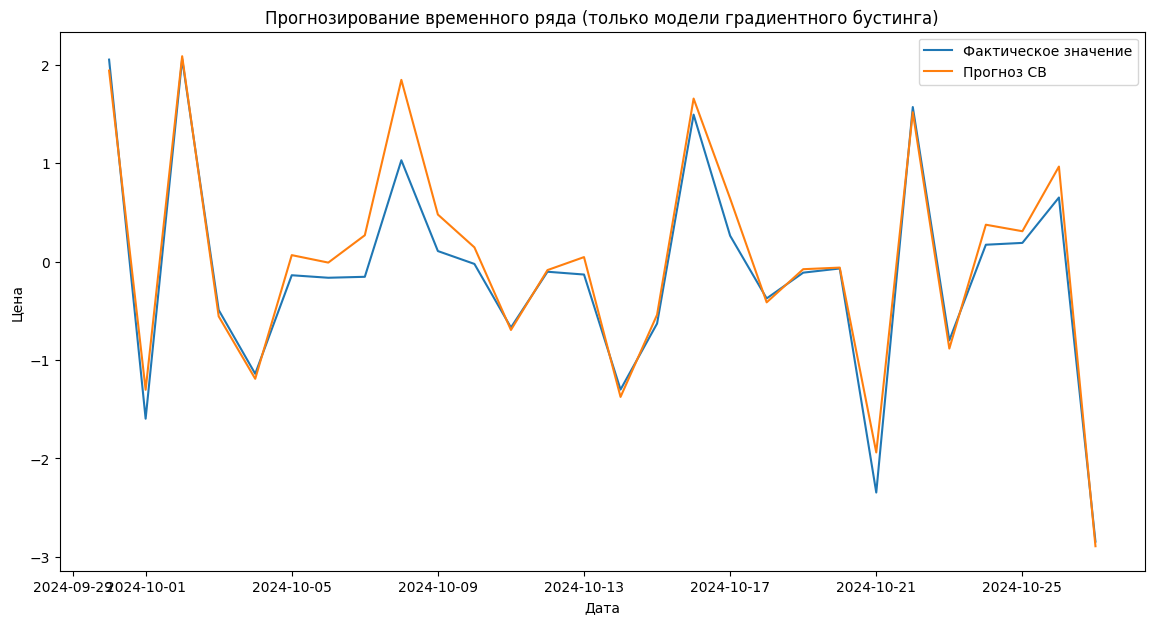

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(y_test.index, y_test, label='Фактическое значение')
# plt.plot(y_test.index, y_pred_xgb, label='Прогноз GB', linestyle='--')
plt.plot(y_test.index, y_pred_cb, label='Прогноз CB', linestyle='-')
# plt.plot(y_test.index, y_pred_lgbm, label='Прогноз LGBM', linestyle=':')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогнозирование временного ряда (только модели градиентного бустинга)')
plt.legend()
plt.show()

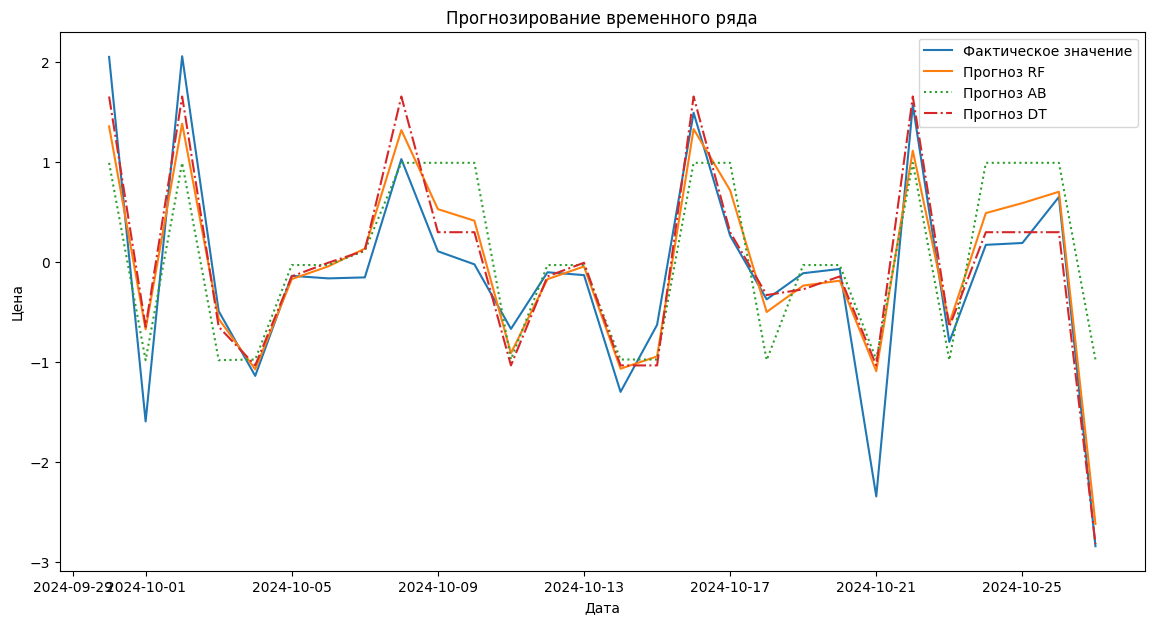

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(y_test.index, y_test, label='Фактическое значение')
plt.plot(y_test.index, y_pred_rf, label='Прогноз RF', linestyle='-')
plt.plot(y_test.index, y_pred_ab, label='Прогноз AB', linestyle=':')
plt.plot(y_test.index, y_pred_dt, label='Прогноз DT', linestyle='-.')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогнозирование временного ряда')
plt.legend()
plt.show()

## Deep learning

### LSTM

### Предобработка и конструирование признаков


In [ ]:
def create_sequences(X, y, seq_length=10):
    X_seq = []
    y_seq = []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)


In [ ]:
df_train, df_val, df_test = split_time_series(df=df, ticker=TICKER)

df_train = extract_time_series_features(df=df_train)
df_val = extract_time_series_features(df=df_val)
df_test = extract_time_series_features(df=df_test)


df_train_processed, transformers_train = preprocess_time_series(df=df_train, target='target', is_train=True)
df_val_processed, transformers_val = preprocess_time_series(df=df_val, target='target', transformers=copy.deepcopy(transformers_train))
df_test_processed, transformers_test = preprocess_time_series(df=df_test, target='target', transformers=copy.deepcopy(transformers_train))

X_train = df_train_processed.drop(columns=['target'])
y_train = df_train_processed['target']
X_val = df_val_processed.drop(columns=['target'])
y_val = df_val_processed['target']
X_test = df_test_processed.drop(columns=['target'])
y_test = df_test_processed['target']

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

seq_length = 10
X_train_seq, y_train_seq = create_sequences(np.insert(X_train_scaled, len(X_train_scaled[0]), y_train.values, axis=1), y_train.values.reshape(-1, 1), seq_length)
X_val_seq, y_val_seq = create_sequences(np.insert(X_val_scaled, len(X_val_scaled[0]), y_val.values, axis=1), y_val.values.reshape(-1, 1), seq_length)
X_test_seq, y_test_seq = create_sequences(np.insert(X_test_scaled, len(X_test_scaled[0]), y_test.values, axis=1), y_test.values.reshape(-1, 1), seq_length)

X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq = torch.tensor(y_train_seq, dtype=torch.float32)
X_val_seq = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_seq = torch.tensor(y_val_seq, dtype=torch.float32)
X_test_seq = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_seq = torch.tensor(y_test_seq, dtype=torch.float32)

### Обучение


In [ ]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size , output_size)


    def forward(self, x):

        lstm_out, _ = self.lstm(x)

        last_out = lstm_out[:, -1, :]

        output = self.fc(last_out)
        return output


input_size = X_train_seq.shape[2]
hidden_size = 128
output_size = 1
num_layers = 2


model = LSTMRegressor(input_size, hidden_size, output_size, num_layers)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


epochs = 30
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()


    y_pred = model(X_train_seq)


    loss = criterion(y_pred, y_train_seq)


    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


### Оценка результатов

In [ ]:
y_train_real = df_train.set_index('Date')['target'].iloc[WINDOW_SIZE:]
y_val_real = df_val.set_index('Date')['target'].iloc[WINDOW_SIZE:]
y_test_real = df_test.set_index('Date')['target'].iloc[WINDOW_SIZE:]

In [ ]:
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_seq)
    val_mse_lstm = mean_squared_error(y_val_seq, y_val_pred)
    val_mae_lstm = mean_absolute_error(y_val_seq, y_val_pred)
    val_mape_lstm = mean_absolute_percentage_error(y_val_seq, y_val_pred)

print("\nValidation Results:")
print(f"MSE: {val_mse_lstm:.4f}")
print(f"MAE: {val_mae_lstm:.4f}")
print(f"MAPE: {val_mape_lstm:.4f}")


with torch.no_grad():
    y_test_pred_lstm = model(X_test_seq)
    test_mse_lstm = mean_squared_error(y_test_seq, y_test_pred_lstm)
    test_mae_lstm = mean_absolute_error(y_test_seq, y_test_pred_lstm)
    test_mape_lstm = mean_absolute_percentage_error(y_test_seq, y_test_pred_lstm)

print("\nTest Results:")
print(f"MSE: {test_mse_lstm:.4f}")
print(f"MAE: {test_mae_lstm:.4f}")
print(f"MAPE: {test_mape_lstm:.4f}")


Validation Results:
MSE: 6.7922
MAE: 1.0100
MAPE: 137347393772201.8906

Test Results:
MSE: 1.9092
MAE: 1.0672
MAPE: 3.7287


In [ ]:
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_seq)
    Y_val_real = y_val_real.values.reshape(-1, 1)[seq_length:]
    y_val_pred_real = inverse_preprocess_time_series(np.concatenate([y_val[:seq_length], y_val_pred.reshape(-1).numpy()]), transformers=transformers_val)[seq_length:]
    val_real_mse_lstm = mean_squared_error(Y_val_real, y_val_pred_real)
    val_real_mae_lstm = mean_absolute_error(Y_val_real, y_val_pred_real)
    val_real_mape_sltm = mean_absolute_percentage_error(Y_val_real, y_val_pred_real)

print("\nValidation Results:")
print(f"MSE: {val_real_mse_lstm:.4f}")
print(f"MAE: {val_real_mae_lstm:.4f}")
print(f"MAPE: {val_real_mape_sltm:.4f}")


with torch.no_grad():
    y_test_pred = model(X_test_seq)
    Y_test_real = y_test_real.values.reshape(-1, 1)[seq_length:]
    y_test_pred_real_lstm = inverse_preprocess_time_series(np.concatenate([y_test[:seq_length], y_test_pred.reshape(-1).numpy()]), transformers=transformers_test)[seq_length:]
    test_real_mse_lstm = mean_squared_error(Y_test_real, y_test_pred_real_lstm)
    test_real_mae_lstm = mean_absolute_error(Y_test_real, y_test_pred_real_lstm)
    test_real_mape_lstm = mean_absolute_percentage_error(Y_test_real, y_test_pred_real_lstm)

print("\nTest Results:")
print(f"MSE: {test_real_mse_lstm:.4f}")
print(f"MAE: {test_real_mae_lstm:.4f}")
print(f"MAPE: {test_real_mape_lstm:.4f}")


Validation Results:
MSE: 366252565678.8380
MAE: 471645.8630
MAPE: 91489262023114113024.0000

Test Results:
MSE: 753.9296
MAE: 11.7994
MAPE: 28359785474490084.0000


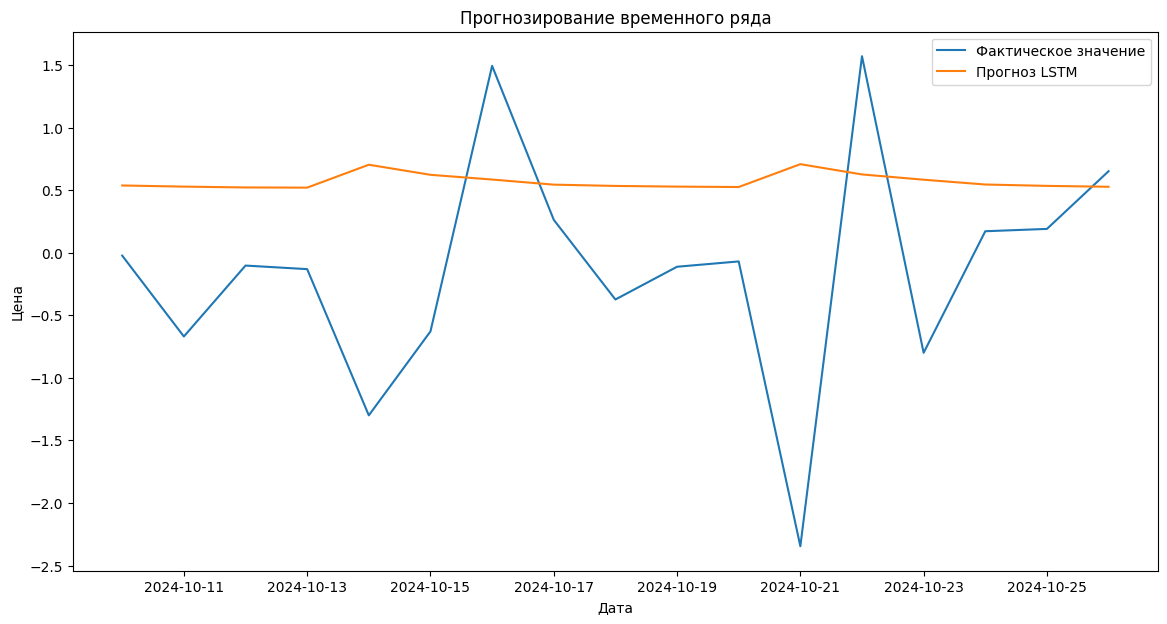

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(y_test.index[seq_length:-1], y_test[seq_length:-1], label='Фактическое значение')
plt.plot(y_test.index[seq_length:-1], y_test_pred_lstm[:-1], label='Прогноз LSTM', linestyle='-')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогнозирование временного ряда')
plt.legend()
plt.show()

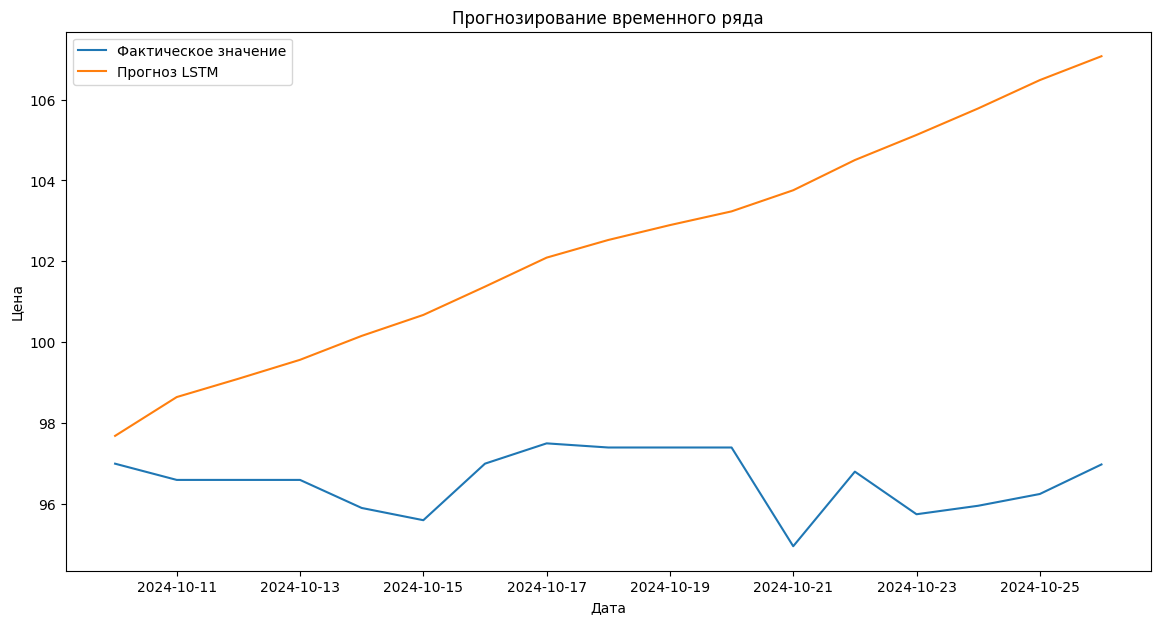

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(y_test_real.index[seq_length:-1], y_test_real[seq_length:-1], label='Фактическое значение')
plt.plot(y_test_real.index[seq_length:-1], y_test_pred_real_lstm[:-1], label='Прогноз LSTM', linestyle='-')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогнозирование временного ряда')
plt.legend()
plt.show()

### TemporalFusionTransformer


### Предобработка и конструирование признаков

In [ ]:
df_train_processed, transformers_train = preprocess_time_series(df=df_train, target='target', is_train=True, do_encode=False)
df_val_processed, transformers_val = preprocess_time_series(df=df_val, target='target', transformers=copy.deepcopy(transformers_train), do_encode=False)
df_test_processed, transformers_test = preprocess_time_series(df=df_test, target='target', transformers=copy.deepcopy(transformers_train), do_encode=False)

In [ ]:
def prepare_tft_dataframe(df_processed, seq_length=10):
    df = df_processed.copy().reset_index()
    df["time_idx"] = df.groupby("ticker").cumcount()
    return df

df_train_tft = prepare_tft_dataframe(df_train_processed)
df_val_tft = prepare_tft_dataframe(df_val_processed)
df_test_tft = prepare_tft_dataframe(df_test_processed)

### Обучение


In [ ]:
def train_and_predict_TFT(max_encoder_length=10, max_prediction_length=1):
    known_reals = [col for col in df_train_tft.columns if col not in ["target", "ticker", "time_idx"]]

    training = TimeSeriesDataSet(
        df_train_tft,
        time_idx="time_idx",
        target="target",
        group_ids=["ticker"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=["ticker"],
        time_varying_known_reals=known_reals,
        time_varying_unknown_reals=["target"],
    )
    validation = TimeSeriesDataSet.from_dataset(training, df_val_tft, stop_randomization=True)
    test = TimeSeriesDataSet.from_dataset(training, df_test_tft, stop_randomization=True)

    train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=64, num_workers=0)
    test_dataloader = test.to_dataloader(train=False, batch_size=64, num_workers=0)

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="checkpoints/",
        filename="best-tft",
        save_top_k=1,
        mode="min"
    )
    early_stop_callback = EarlyStopping(
        monitor="val_loss",
        patience=5,
        mode="min"
    )

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=1e-3,
        hidden_size=128,
        attention_head_size=8,
        dropout=0.1,
        loss=MeanSquaredError(),
        log_interval=10,
        reduce_on_plateau_patience=3,
        lstm_layers=2
    )

    trainer = Trainer(
        max_epochs=30,
        gradient_clip_val=0.1,
        callbacks=[checkpoint_callback, early_stop_callback]
    )

    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )

    best_model_path = checkpoint_callback.best_model_path
    best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

    return best_tft.predict(test_dataloader).cpu()


### Оценка результатов

In [ ]:
seq_length = 10
y_test_pred_tft = train_and_predict_TFT().reshape(-1).numpy()
Y_test = y_test.values.reshape(-1, 1)[seq_length:]
test_mse_tft = mean_squared_error(Y_test, y_test_pred_tft)
test_mae_tft = mean_absolute_error(Y_test, y_test_pred_tft)
test_mape_tft = mean_absolute_percentage_error(Y_test, y_test_pred_tft)

print("\nTest Results:")
print(f"MSE: {test_mse_tft:.4f}")
print(f"MAE: {test_mae_tft:.4f}")
print(f"MAPE: {test_mape_tft:.4f}")

/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | lo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.
/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV


Test Results:
MSE: 0.7298
MAE: 0.7651
MAPE: 5.3972


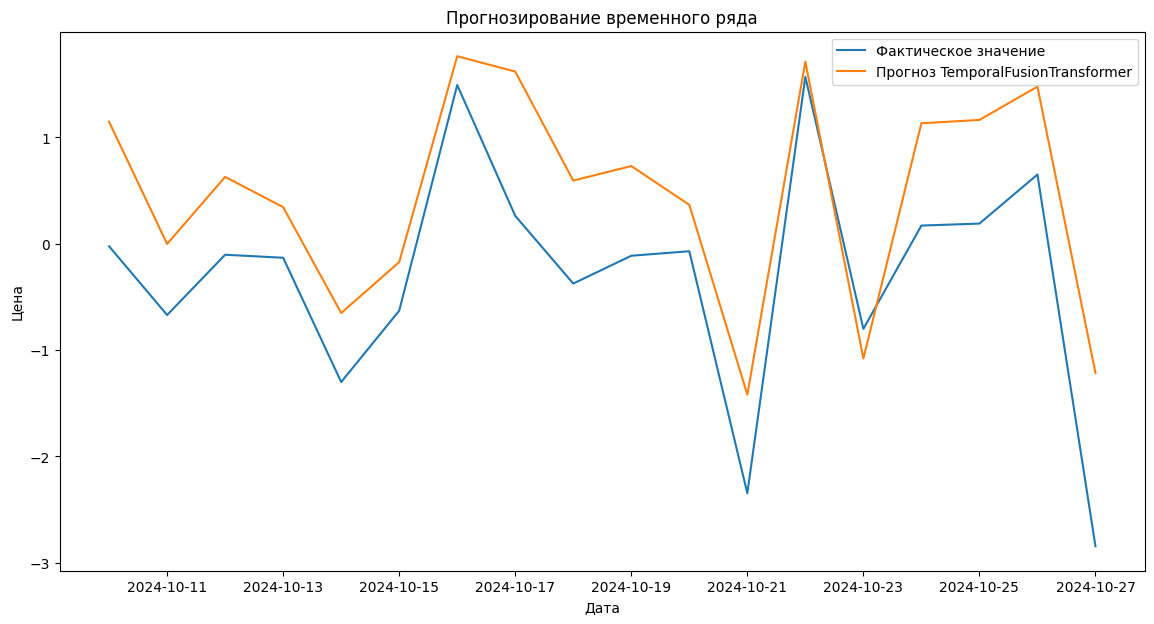

In [ ]:
seq_length = 10
plt.figure(figsize=(14, 7))

plt.plot(y_test.index[seq_length:], y_test[seq_length:], label='Фактическое значение')
plt.plot(y_test.index[seq_length:], y_test_pred_tft, label='Прогноз TemporalFusionTransformer', linestyle='-')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогнозирование временного ряда')
plt.legend()
plt.show()

In [ ]:
Y_test_real = y_test_real.values.reshape(-1, 1)[seq_length:]
y_test_pred_real_tft = inverse_preprocess_time_series(np.concatenate([y_test[:seq_length], y_test_pred_tft.reshape(-1)]), transformers=transformers_test)[seq_length:]
test_real_mse_tft = mean_squared_error(Y_test_real, y_test_pred_real_tft)
test_real_mae_tft = mean_absolute_error(Y_test_real, y_test_pred_real_tft)
test_real_mape_tft = mean_absolute_percentage_error(Y_test_real, y_test_pred_real_tft)

print("\nTest Results:")
print(f"MSE: {test_real_mse_tft:.4f}")
print(f"MAE: {test_real_mae_tft:.4f}")
print(f"MAPE: {test_real_mape_tft:.4f}")


Test Results:
MSE: 236.4074
MAE: 8.5409
MAPE: 15085412081143638.0000


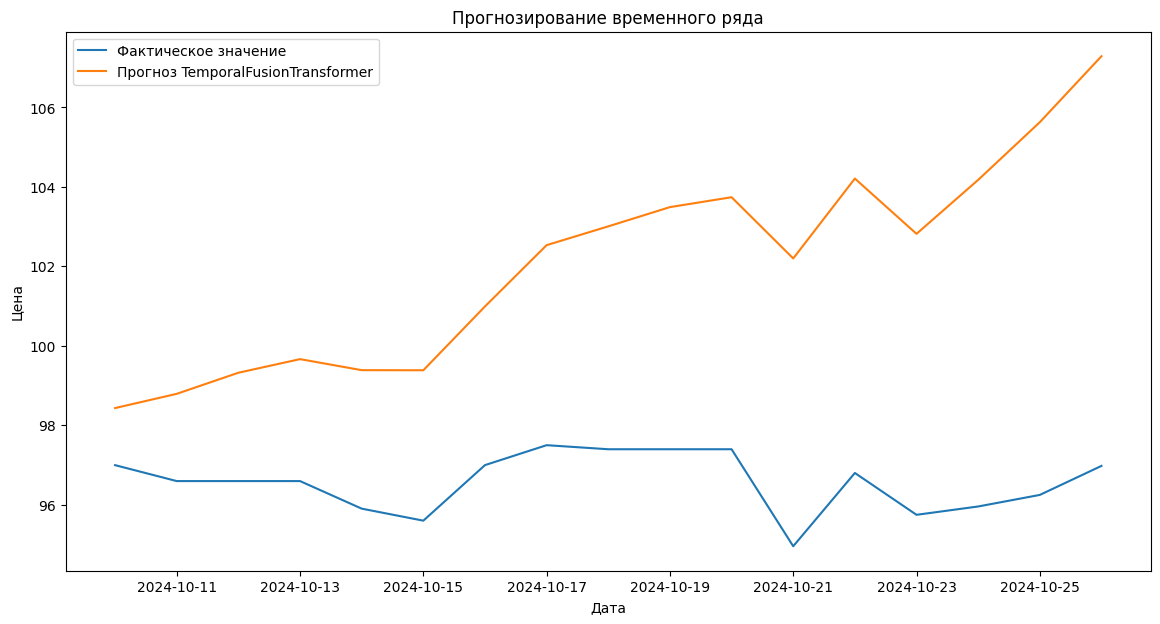

In [ ]:
seq_length = 10

y_test_real_trimmed = y_test_real[:-1]
y_test_pred_real_tft_trimmed = y_test_pred_real_tft[:-1]

plt.figure(figsize=(14, 7))

plt.plot(y_test_real_trimmed.index[seq_length:], y_test_real_trimmed[seq_length:], label='Фактическое значение')
plt.plot(y_test_real_trimmed.index[seq_length:], y_test_pred_real_tft_trimmed, label='Прогноз TemporalFusionTransformer', linestyle='-')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогнозирование временного ряда')
plt.legend()
plt.show()


### Итеративное предсказание на 14 дней вперёд


In [ ]:
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting import TimeSeriesDataSet
import pandas as pd
from copy import deepcopy
import torch

best_tft = TemporalFusionTransformer.load_from_checkpoint("checkpoints/best-tft.ckpt")

best_tft.eval()
best_tft.to("cuda" if torch.cuda.is_available() else "cpu")

known_reals = [col for col in df_train_tft.columns if col not in ["target", "ticker", "time_idx"]]

training = TimeSeriesDataSet(
    df_train_tft,
    time_idx="time_idx",
    target="target",
    group_ids=["ticker"],
    max_encoder_length=10,
    max_prediction_length=1,
    static_categoricals=["ticker"],
    time_varying_known_reals=known_reals,
    time_varying_unknown_reals=["target"],
)

df_iter = deepcopy(df_test_tft[:-14])

last_time_idx = df_iter["time_idx"].max()

predictions = []

for step in range(14):
    predict_dataset = TimeSeriesDataSet.from_dataset(
        training, df_iter, predict=True, stop_randomization=True
    )
    predict_loader = predict_dataset.to_dataloader(train=False, batch_size=64, num_workers=0)

    pred = best_tft.predict(predict_loader).cpu().numpy().flatten()
    predictions.append(pred[0])

    new_rows = []

    for ticker in df_iter["ticker"].unique():
        latest_row = df_iter[df_iter["ticker"] == ticker].iloc[-1:].copy()
        latest_row["time_idx"] = last_time_idx + 1
        latest_row["target"] = pred[0]
        new_rows.append(latest_row)

    df_iter = pd.concat([df_iter] + new_rows, ignore_index=True)
    last_time_idx += 1


forecast_14 = np.array(predictions)
print("\n📈 Предсказания на 14 дней вперёд:")
print(forecast_14)


/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/analyst/.cache/pypoetry/virtuale


📈 Предсказания на 14 дней вперёд:
[0.34439412 0.39446962 0.41686198 0.40185174 0.34411293 0.2935982
 0.2832301  0.28599647 0.26626664 0.25534454 0.25703737 0.25698096
 0.2573138  0.25760376]


/home/analyst/.cache/pypoetry/virtualenvs/topic-4pTwHYyi-py3.11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=5` in the `DataLoader` to improve performance.


## Оценка результатов

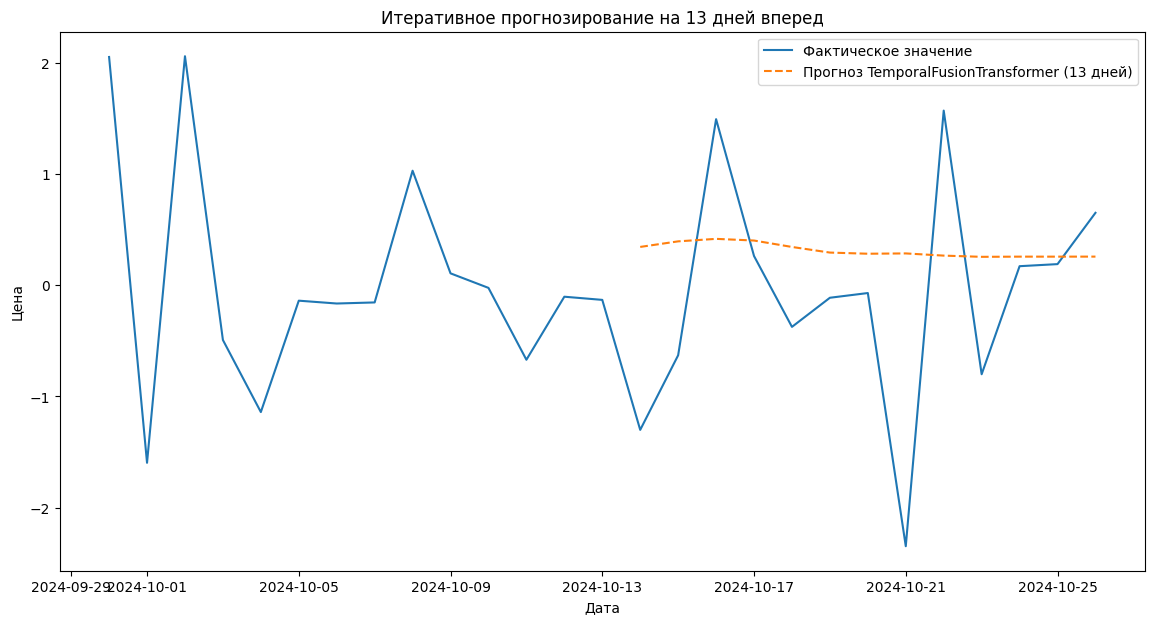

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

forecast_14 = np.array(predictions[:-1])

forecast_dates = pd.date_range(y_test.index[-14], periods=13, freq='D')
y_test_trimmed = y_test[:-1]

plt.figure(figsize=(14, 7))

plt.plot(y_test_trimmed.index, y_test_trimmed.values, label='Фактическое значение')

plt.plot(forecast_dates, forecast_14, label='Прогноз TemporalFusionTransformer (13 дней)', linestyle='--')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Итеративное прогнозирование на 13 дней вперед')
plt.legend()

plt.show()


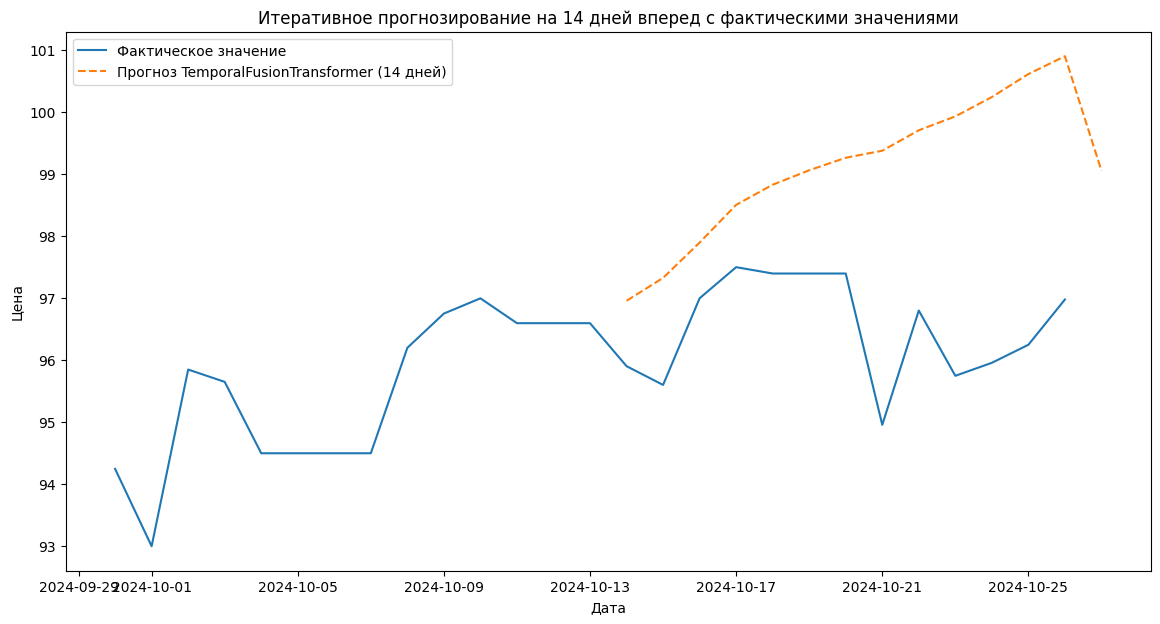

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

max_prediction_length = 14
seq_length = 10

forecast_14 = np.array(predictions)
Y_test_real = y_test_real.values.reshape(-1, 1)[-max_prediction_length:]
y_test_pred_real_two_weeks_tft = inverse_preprocess_time_series(np.concatenate([y_test[:-max_prediction_length], forecast_14]), transformers=transformers_test)[-max_prediction_length:]

forecast_dates = pd.date_range(y_test.index[-14], periods=14, freq='D')

plt.figure(figsize=(14, 7))

plt.plot(y_test_real.index[:-1], y_test_real.values[:-1], label='Фактическое значение')

plt.plot(forecast_dates, y_test_pred_real_two_weeks_tft, label='Прогноз TemporalFusionTransformer (14 дней)', linestyle='--')

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Итеративное прогнозирование на 14 дней вперед с фактическими значениями')
plt.legend()

plt.show()

## Сравнение LSTM и TemporalFusionTransformer

In [ ]:
df_models = pd.DataFrame(
    data=None,
    columns=['Model', 'MSE', 'MAE', 'MAPE'],
    index=None
)

df_models.loc[1] = ['LSTM', test_mse_lstm, test_mae_lstm, test_mape_lstm]
df_models.loc[2] = ['TemporalFusionTransformer', test_mse_tft, test_mae_tft, test_mape_tft]

df_models.sort_values(by=['MSE', 'MAE', 'MAPE'], ascending=True)

,Model,MSE,MAE,MAPE
2,TemporalFusionTransformer,0.729785,0.765099,5.397190
1,LSTM,1.909195,1.067170,3.728729


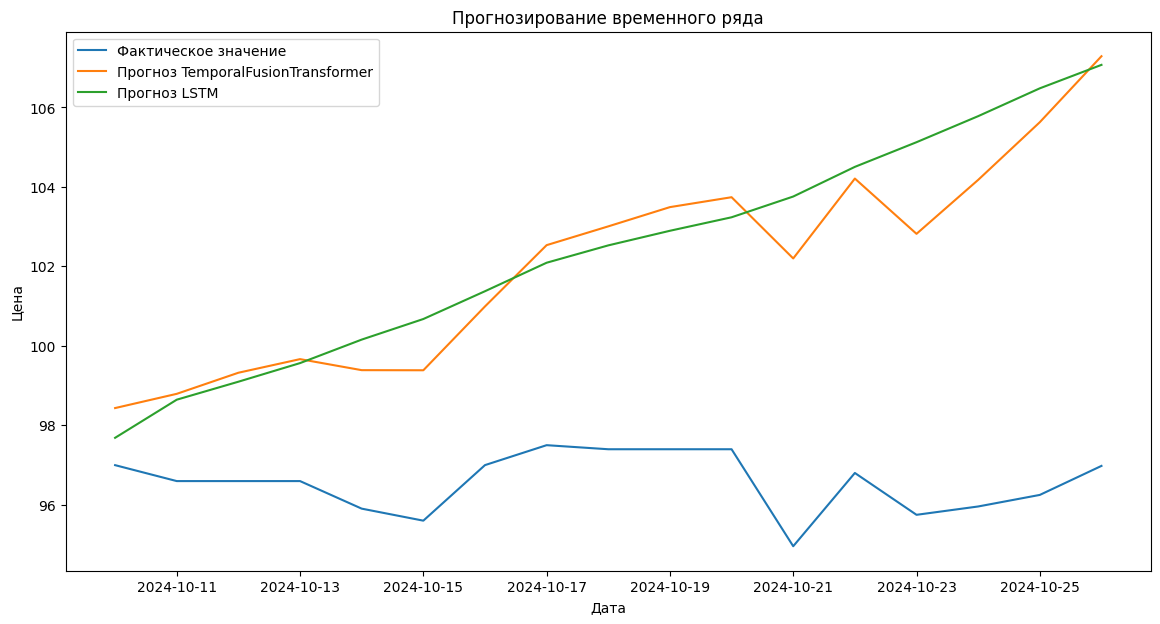

In [ ]:
seq_length = 10

y_test_real_trimmed = y_test_real[:-1]
y_test_pred_real_tft_trimmed = y_test_pred_real_tft[:-1]
y_test_pred_real_lstm_trimmed = y_test_pred_real_lstm[:-1]

plt.figure(figsize=(14, 7))

plt.plot(
    y_test_real_trimmed.index[seq_length:],
    y_test_real_trimmed[seq_length:],
    label='Фактическое значение'
)
plt.plot(
    y_test_real_trimmed.index[seq_length:],
    y_test_pred_real_tft_trimmed,
    label='Прогноз TemporalFusionTransformer',
    linestyle='-'
)
plt.plot(
    y_test_real_trimmed.index[seq_length:],
    y_test_pred_real_lstm_trimmed,
    label='Прогноз LSTM',
    linestyle='-'
)

plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогнозирование временного ряда')
plt.legend()
plt.show()
